In [1]:
import json
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.dpi"] = 300

In [2]:
experiment_id = "RXN00026"
measurement_file = Path(f"sample_data/{experiment_id}.CSV")

### Recalculating O2 concentrations from raw voltages

The Arduino code uses the dry calibration values for OXY1 (to be used pre-reaction with gas straight from the cylinder(s)) and the wet calibration values for OXY2 (post-reaction). If that works for your reaction you can directly use the O2 concentrations reported by the Arduino.

If your reaction is not in water and you need accurate post-reaction values you should use the raw voltages from the sensor and convert to %O2 using the appropriate calibration values. The following code will help you do that.

In [3]:
calibration_file = Path(".") / "calibration" / "calibration_values.json"
with open(calibration_file) as f:
    calibration_values = json.load(f)

@dataclass
class CalibrationValues:
    v: float  # voltage during measurement in open air (20.95% O2)
    v_0: float  # voltage during measurement in N2
    p: float  # pressure, kPa
    rh: float  # relative humidity, %
    t: float  # temperature, C
    cf: float # calibration factor

dry_cv_1 = calibration_values["dry"]["oxy1"]
oxy1_dry = CalibrationValues(dry_cv_1["Vc"], dry_cv_1["V0"], dry_cv_1["Pc"], dry_cv_1["RH"], dry_cv_1["Tc"], dry_cv_1["calibration_factor"])
dry_cv_2 = calibration_values["dry"]["oxy2"]
oxy2_dry = CalibrationValues(dry_cv_2["Vc"], dry_cv_2["V0"], dry_cv_2["Pc"], dry_cv_2["RH"], dry_cv_2["Tc"], dry_cv_2["calibration_factor"])
wet_cv_1 = calibration_values["wet"]["oxy1"]
oxy1_wet = CalibrationValues(wet_cv_1["Vc"], wet_cv_1["V0"], wet_cv_1["Pc"], wet_cv_1["RH"], wet_cv_1["Tc"], wet_cv_1["calibration_factor"])
wet_cv_2 = calibration_values["wet"]["oxy2"]
oxy2_wet = CalibrationValues(wet_cv_2["Vc"], wet_cv_2["V0"], wet_cv_2["Pc"], wet_cv_2["RH"], wet_cv_2["Tc"], wet_cv_2["calibration_factor"])

def oxy_volt_to_percent(
    volt: float,
    temp: float,
    pressure: float,
    humidity: float,
    cal: CalibrationValues,
    assume_zero_RH: bool = False,
) -> float:
    """
    Converts oxygen sensor voltage to oxygen percentage.
    """
    p_vapor = (
        lambda t, rh: (rh / 100)
        * 0.61121
        * np.exp(t * (18.678 - t / 234.5) / (t + 257.14))
    )
    c1, c2, c3 = -0.06949, 0.001422, -0.0000008213
    if assume_zero_RH:
        humidity = 0
    oxy_percent = cal.cf * (volt - cal.v_0) * (cal.p / pressure) * (
        (cal.p + p_vapor(temp, humidity) - p_vapor(cal.t, cal.rh)) / cal.p
    ) + (
        c3 * temp**3
        + c2 * temp**2
        + c1 * temp
        - c3 * cal.t**3
        - c2 * cal.t**2
        - c1 * cal.t
    )
    return oxy_percent


def df_oxy_volt_to_percent(
    df: pd.DataFrame,
    sensor: str,  # "oxy1" or "oxy2"
    cal: CalibrationValues,
    assume_zero_RH: bool = False,
):
    """ 
    Replaces the oxygen percentage values in the given dataframe for the given sensor.

    `assume_zero_RH`: when False, uses the humidity measured from the humidity sensor.
    When True, assumes the humidity is zero -- use when doing air-free reactions.
    """
    volt_col = {"oxy1": "oxy1_voltage (V)", "oxy2": "oxy2_voltage (V)"}[sensor]
    temp_col = {"oxy1": "oxy1_temp (C)", "oxy2": "oxy2_temp (C)"}[sensor]
    oxy_col = {"oxy1": "oxy1_O2 (%)", "oxy2": "oxy2_O2 (%)"}[sensor]
    df[oxy_col] = oxy_volt_to_percent(
        df[volt_col],
        df[temp_col],
        df["pressure (kPa)"],
        df["humidity (%)"],
        cal,
        assume_zero_RH,
    )

The example reaction shown here was an air-free reaction, so we'll use the dry calibration values for both OXY1 and OXY2.

In [4]:
data = pd.read_csv(measurement_file, skiprows=4)
data["elapsed_time"] = data["time (s)"] - data["time (s)"].iloc[0]

df_oxy_volt_to_percent(data, "oxy1", oxy1_dry, assume_zero_RH=True)
df_oxy_volt_to_percent(data, "oxy2", oxy2_dry, assume_zero_RH=True)

The reaction monitor has flow sensors for two different ranges of gas flow: 20-100 mL/min and 100-500 mL/min. For convenience when plotting the data, the code below adds a "flow" column which shows the flow rate from whatever the active sensor is and removes the oxygen percentages when there is zero flow (which, in our reactions, means the reation is under vacuum).

In [5]:
# create column for flow rate that only uses the active sensor
# note: this might run into problems if you change the active sensor, specifically in the transition region
flow = pd.DataFrame()
flow["flow1"] = data["flow1_flow (mL/min)"].mask(data["flow1_voltage (V)"] < 0.1, 0)
flow["flow2"] = data["flow2_flow (mL/min)"].mask(data["flow2_voltage (V)"] < 0.1, 0)
flow["flow"] = flow["flow1"] + flow["flow2"]
data["flow"] = flow["flow"]

# remove oxygen data where flow is zero
data["oxy1_O2 (%)"].mask(data["flow"] == 0, inplace=True)
data["oxy2_O2 (%)"].mask(data["flow"] == 0, inplace=True)

# replace 0 with NaN so it doesn't get plotted
data["flow"].mask(data["flow"] == 0, inplace=True)
data["oxy1_O2 (%)"].mask(data["oxy1_O2 (%)"] == 0, inplace=True)
data["oxy2_O2 (%)"].mask(data["oxy2_O2 (%)"] == 0, inplace=True)

Any user intervention regarding the PID controller's control method or PID profile is logged. Any visualization that we do should probably include this information, as it would otherwise go unnoticed.

In [6]:
# create log of changes made using temperature controller
control_method = {0: "PID", 1: "ON/OFF", 2: "Manual", 3: "PID Program Control"}

change_log = []
prev_ctrl = ""
prev_pid_profile = ""
for row in data.iterrows():
    if row[1]["Control Method"] != prev_ctrl:
        change_log.append(
            (
                row[0],
                row[1]["elapsed_time"],
                f'Control method changed to {control_method[int(row[1]["Control Method"])]}',
            )
        )
    if row[1]["PID profile"] != prev_pid_profile:
        change_log.append(
            (
                row[0],
                row[1]["elapsed_time"],
                f'PID profile changed to {int(row[1]["PID profile"])}',
            )
        )
    prev_ctrl = row[1]["Control Method"]
    prev_pid_profile = row[1]["PID profile"]
change_log

[(0, 0.0, 'Control method changed to PID'),
 (0, 0.0, 'PID profile changed to 3'),
 (2909, 2913.0, 'PID profile changed to 1'),
 (2918, 2922.0, 'Control method changed to PID Program Control'),
 (6771, 6781.0, 'Control method changed to PID')]

Now plot the data.

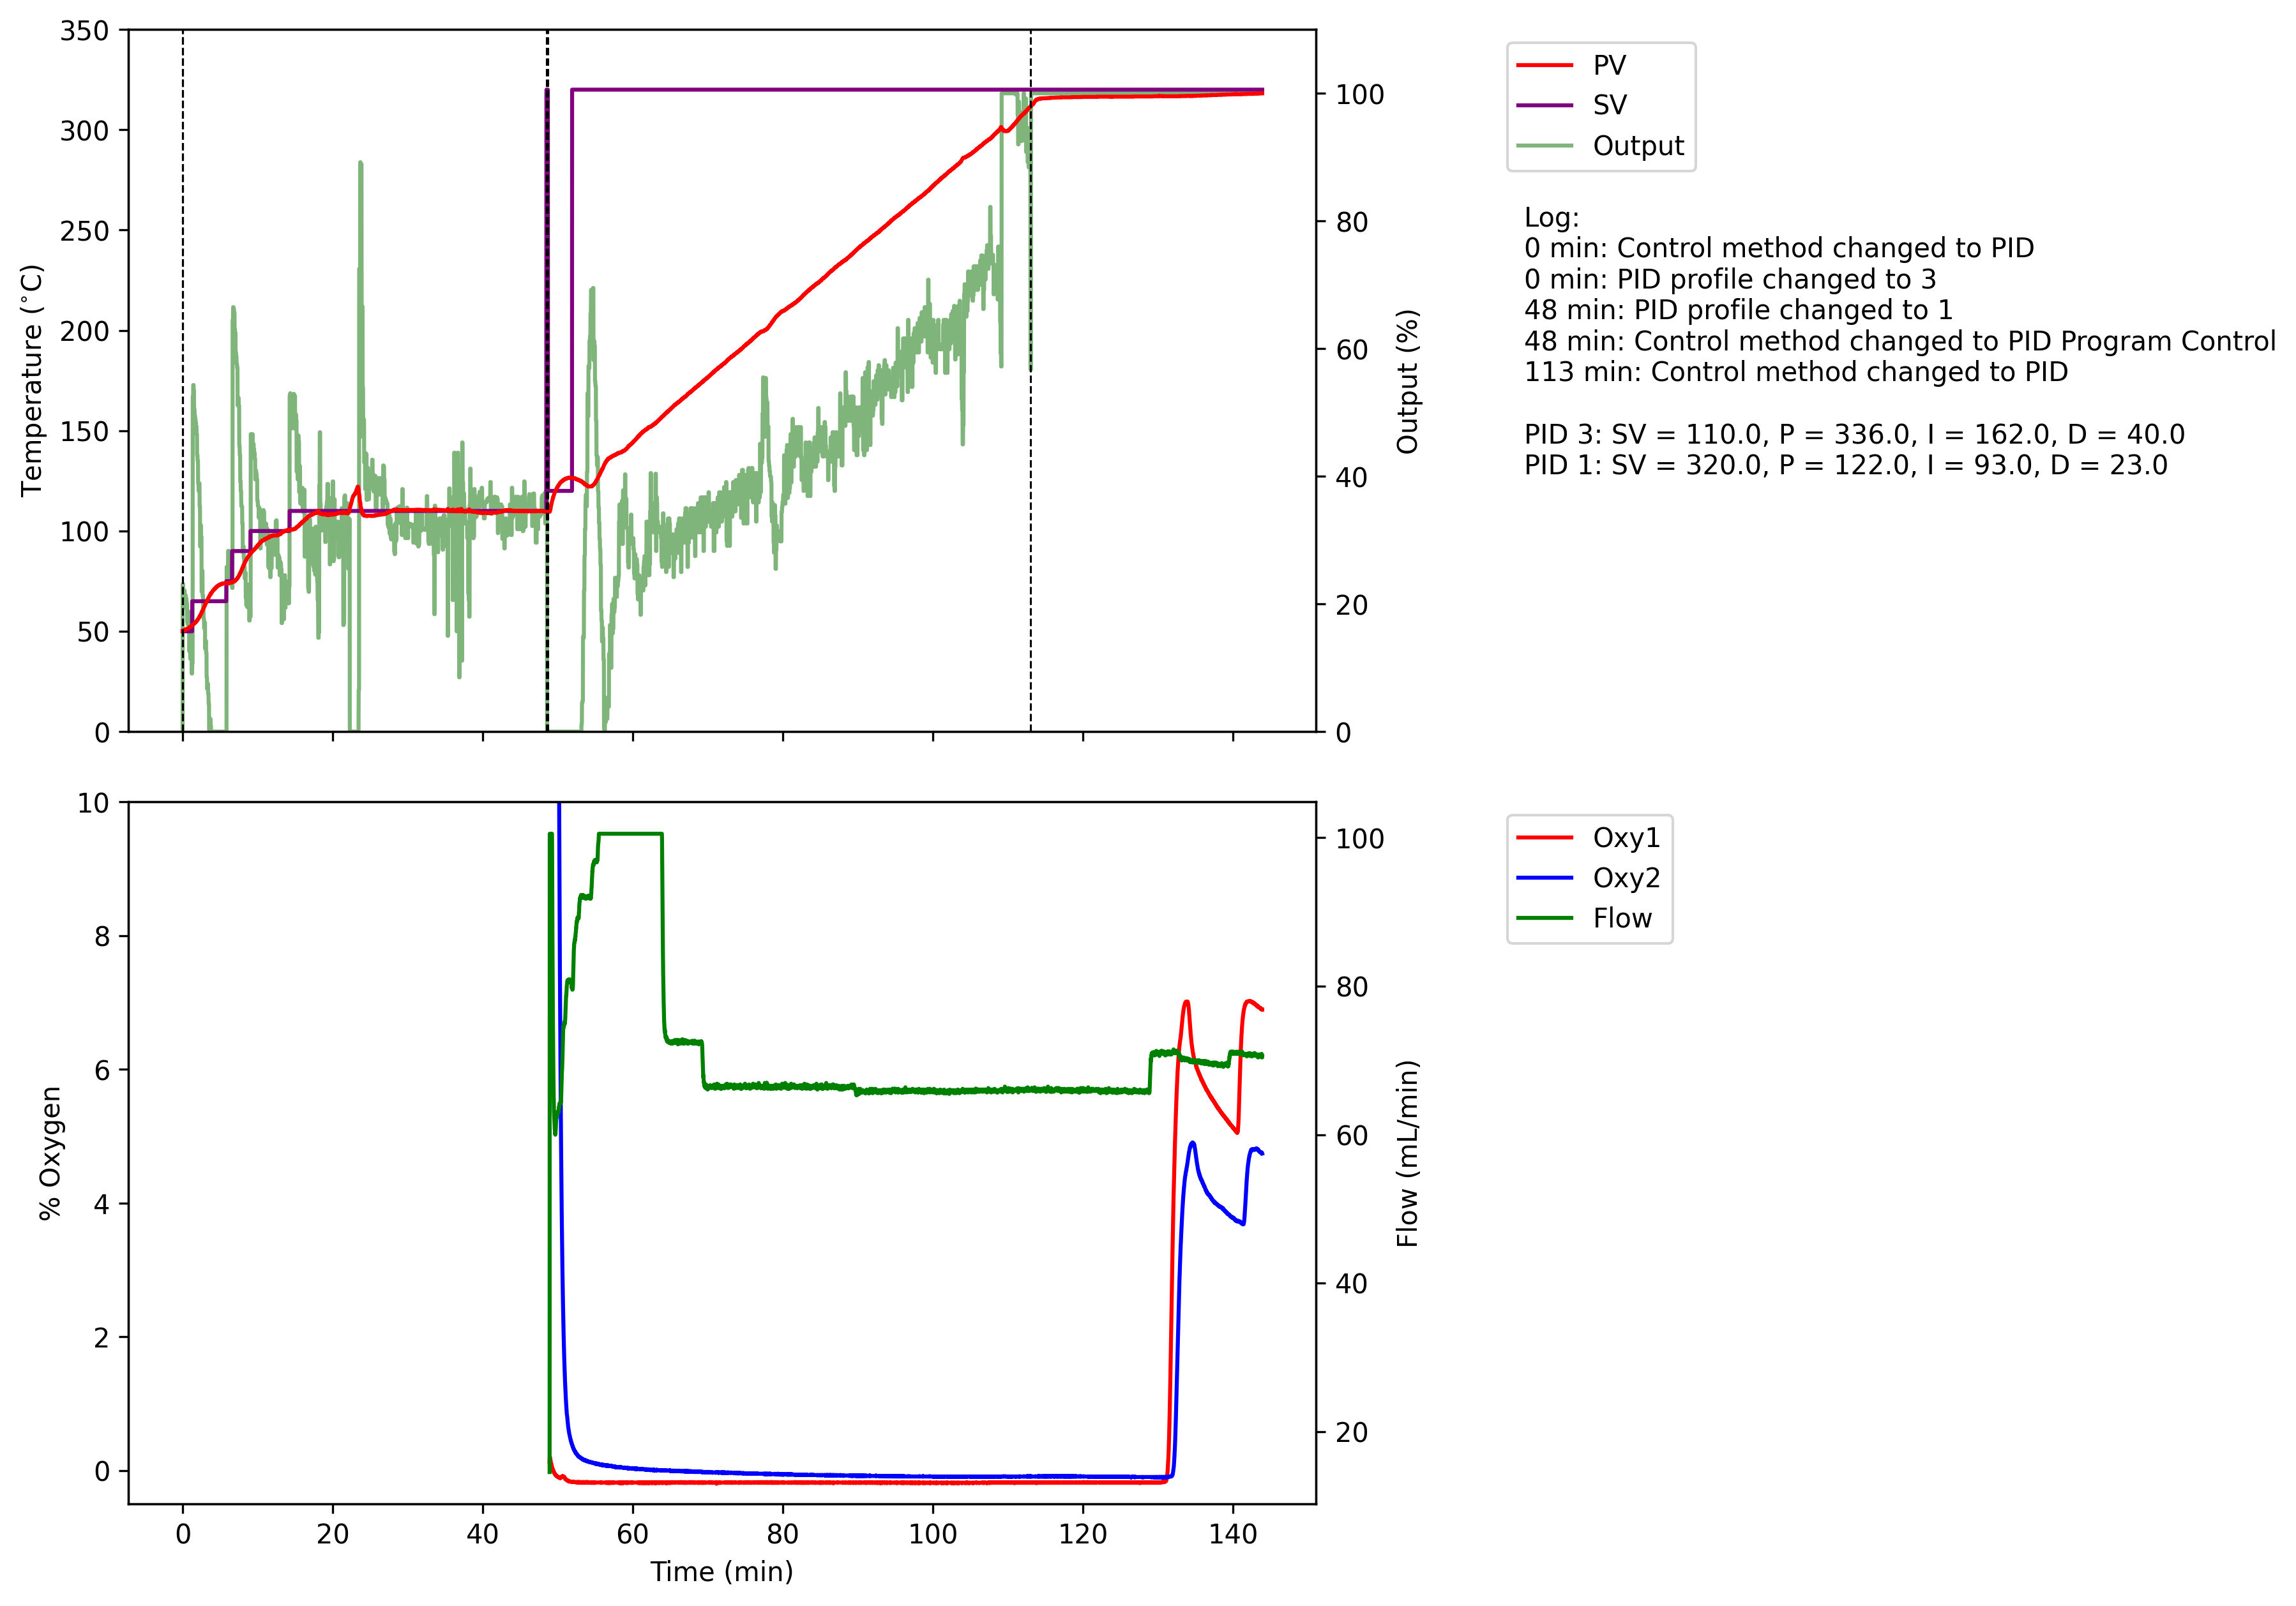

In [7]:
fig, (ax1a, ax2a) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
plt.subplots_adjust(hspace=0.1)
# ax1a.set_title("Reaction X", fontsize=16)
ax2a.set_xlabel("Time (min)")
ax1a.set_ylabel("Temperature ($^{\circ}$C)")
ax1a.set_ylim(0, 350)
ax1b = ax1a.twinx()
ax1b.set_ylabel("Output (%)")
ax1b.set_ylim(0, 110)
ax2a.set_ylabel("% Oxygen")
ax2b = ax2a.twinx()
ax2b.set_ylabel("Flow (mL/min)")
ax1_ln1 = ax1a.plot(
    data["elapsed_time"] / 60, data["PV (C)"], label="PV", c="red", zorder=2
)
ax1_ln2 = ax1a.plot(
    data["elapsed_time"] / 60, data["SV (C)"], label="SV", c="purple", zorder=1
)
ax1_ln3 = ax1b.plot(
    data["elapsed_time"] / 60, data["Output"] / 10, label="Output", c="#7fb57b"
)
ax2_ln1 = ax2a.plot(
    data["elapsed_time"] / 60, data["oxy1_O2 (%)"], label="Oxy1", c="red"
)
ax2_ln2 = ax2a.plot(
    data["elapsed_time"] / 60, data["oxy2_O2 (%)"], label="Oxy2", c="blue"
)
ax2_ln3 = ax2b.plot(data["elapsed_time"] / 60, data["flow"], label="Flow", c="green")
ax2a.set_ylim(-0.5, 10)
ax1_lns = ax1_ln1 + ax1_ln2 + ax1_ln3
ax1_labels = [l.get_label() for l in ax1_lns]
ax2_lns = ax2_ln1 + ax2_ln2 + ax2_ln3
ax2_labels = [l.get_label() for l in ax2_lns]
ax1_legend = ax1a.legend(
    ax1_lns, ax1_labels, loc="upper left", bbox_to_anchor=(1.15, 1)
)
ax2_legend = ax2a.legend(
    ax2_lns, ax2_labels, loc="upper left", bbox_to_anchor=(1.15, 1)
)
ax1b.set_zorder(1)
ax1a.set_zorder(2)
ax1a.patch.set_visible(False)

for entry in change_log:
    ax1a.axvline(x=entry[1] / 60, color="black", linestyle="--", linewidth=0.75)
text = "Log: \n"
for entry in change_log:
    text += f"{int(entry[1]/60)} min: {entry[2]}\n"
text += "\n"
for profile in data["PID profile"].unique():
    sv = data[data["PID profile"] == profile]["PID SV"].iloc[0]
    p = data[data["PID profile"] == profile].iloc[0]["P"]
    i = data[data["PID profile"] == profile].iloc[0]["I"]
    d = data[data["PID profile"] == profile].iloc[0]["D"]
    text += f"PID {profile}: SV = {sv}, P = {p}, I = {i}, D = {d}\n"
ax1a.text(
    1.175,
    0.75,
    text,
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax1a.transAxes,
)
figure_file = Path(f"sample_data/{experiment_id}.png").resolve()
plt.savefig(figure_file, dpi=300, bbox_inches="tight")